Import modules

In [1]:
%matplotlib inline
import os
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
import seaborn
#import seaborn.xkcd_rgb as colors
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

Configure local environment-specific values

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## tax-credit-data repository. 
project_dir = expandvars('$HOME/tax-credit-data/')

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)


# we can save plots in this directory
outdir = join(project_dir, "plots")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
project_dir

'/home/mosele/tax-credit-data/'

In [4]:
#dataset_ids = ['mock-3']
dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5','mock-6', 'mock-7', 'mock-8','mock-12','mock-13',
               'mock-14', 'mock-15', 'mock-16','mock-18', 'mock-19', 'mock-20', 'mock-21', 'mock-22']
method_ids = ['q2-NB', 'q2-SFM-RF', 'q2-SFM-SDG','q2-SFM-NB']
ref_ids = ['gg_13_8_otus']

Find mock community pre-computed tables, expected tables, and "query" tables

Note: if you have added additional methods to add, set append=True. If you are attempting to recompute pre-computed results, set force=True.

This cell will take a few minutes to run if new results are being added, so hold onto your hat. If you are attempting to re-compute everything, it may take an hour or so, so go take a nap.

In [5]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                dataset_ids=dataset_ids,
                                reference_ids=ref_ids,
                                method_ids=method_ids,
                                append=False,
                                force=True, #force=True the first time 
                                backup=False)

Compute and summarize precision, recall, and F-measure for mock communities

In [6]:
color_palette={ 
    'q2-NB':'black',
    'q2-SFM-RF':'darkgreen',
    'q2-SFM-SDG':'red',
    'q2-SFM-NB':'blue',
    }

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


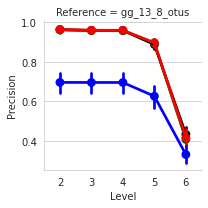

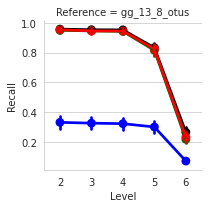

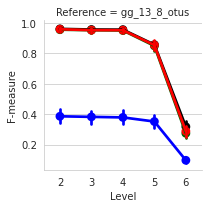

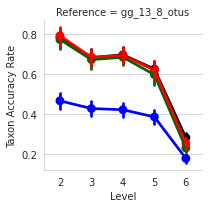

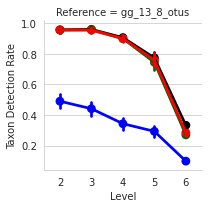

In [7]:
point = pointplot_from_data_frame(mock_results, "Level", y_vars, 
                                  group_by="Reference", color_by="Method",
                                  color_palette=color_palette)

In [8]:
for k, v in point.items():
    v.savefig(join(outdir, 'mock-{0}-lineplots.pdf'.format(k)))

Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database

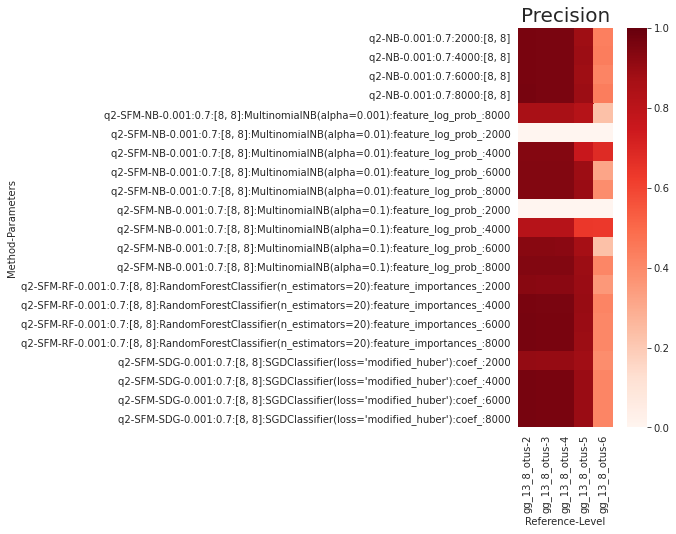

In [9]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

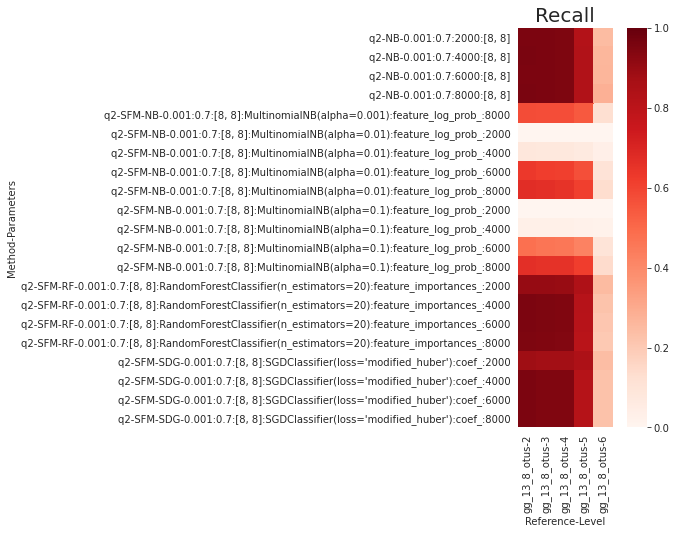

In [10]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

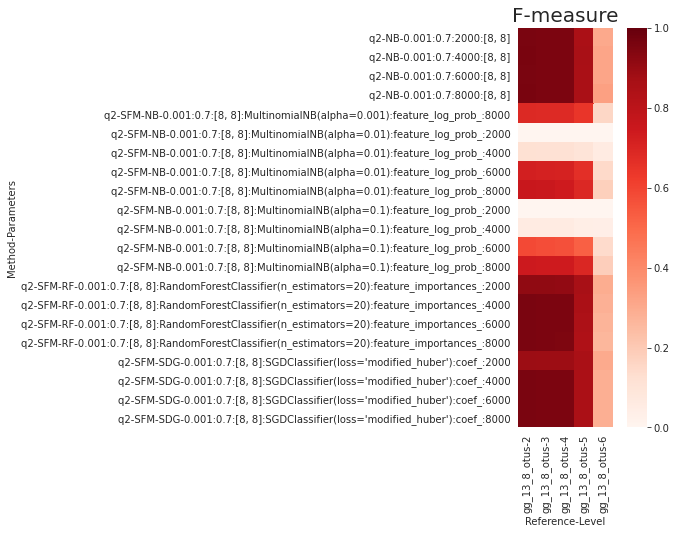

In [11]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

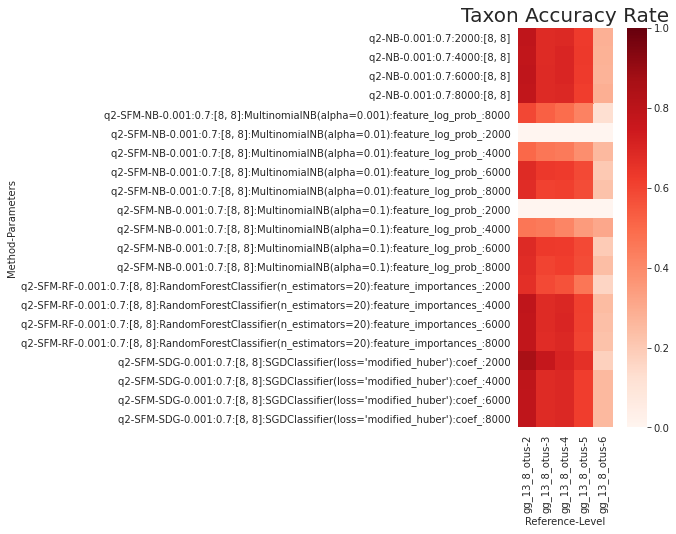

In [12]:
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

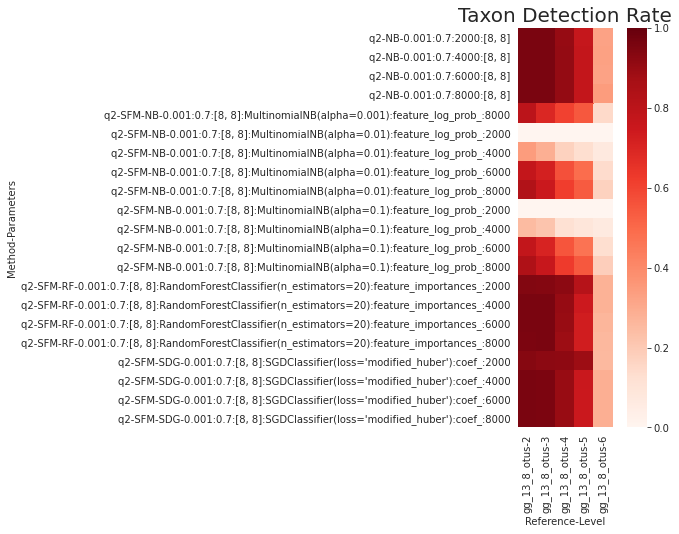

In [13]:
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

now we will focus on results at species level (for genus level, change to level 5)

Method optimization

Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [14]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

pd.set_option('display.max_colwidth', None)
for dataset in mock_results_6['Dataset'].unique():
    display(Markdown('## {0}'.format(dataset)))
    best = method_by_dataset_a1(mock_results_6, dataset)
    display(best)

## mock-20

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
4,q2-NB,"0.001:0.7:8000:[8, 8]",0.431430,0.322209,0.368905,0.291667,0.368421
39,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",0.425668,0.314717,0.361879,0.240000,0.315789
49,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.358282,0.237079,0.285344,0.200000,0.263158
104,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.119167,0.212956,0.500000,0.105263


## mock-3

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
183,q2-NB,"0.001:0.7:6000:[8, 8]",0.453090,0.157622,0.233881,0.384615,0.25
204,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.437113,0.131325,0.201971,0.214286,0.15
284,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.436794,0.131325,0.201937,0.214286,0.15
384,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",0.496680,0.081928,0.140654,0.166667,0.10


## mock-2

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
494,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.783545,0.594806,0.676253,0.348837,0.405405
514,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.728003,0.594806,0.654698,0.365854,0.405405
469,q2-NB,"0.001:0.7:8000:[8, 8]",0.652199,0.594806,0.622181,0.365854,0.405405
534,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",0.682014,0.352422,0.464711,0.352941,0.324324


## mock-21

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
559,q2-NB,"0.001:0.7:8000:[8, 8]",0.635348,0.366473,0.464829,0.272727,0.315789
594,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",0.633236,0.363151,0.461588,0.227273,0.263158
604,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.609409,0.328168,0.426607,0.181818,0.210526
659,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.003817,0.007605,0.333333,0.052632


## mock-18

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
684,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:2000",0.594351,0.435689,0.502801,0.294118,0.333333
664,q2-NB,"0.001:0.7:8000:[8, 8]",0.557428,0.435689,0.489097,0.294118,0.333333
704,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.509354,0.435689,0.469651,0.312500,0.333333
739,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.557550,0.248758,0.344025,0.363636,0.266667


## mock-4

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
819,q2-NB,"0.001:0.7:2000:[8, 8]",0.488018,0.156813,0.237356,0.269231,0.35
859,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.456503,0.137983,0.211913,0.240000,0.30
939,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.456148,0.137983,0.211874,0.222222,0.30
1059,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.469844,0.083801,0.142233,0.190476,0.20


## mock-19

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1144,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:2000",0.369150,0.264054,0.307880,0.238095,0.333333
1179,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:2000",0.369137,0.264054,0.307876,0.250000,0.333333
1124,q2-NB,"0.001:0.7:8000:[8, 8]",0.356575,0.264054,0.303418,0.250000,0.333333
1184,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:6000",0.000000,0.000000,0.000000,0.000000,0.000000


## mock-15

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1229,q2-NB,"0.001:0.7:8000:[8, 8]",0.334856,0.272225,0.300310,0.074468,0.35
1264,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",0.299311,0.222645,0.255348,0.066667,0.30
1274,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.179935,0.118642,0.142997,0.054348,0.25
1324,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.055743,0.105600,0.181818,0.10


## mock-5

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1364,q2-NB,"0.001:0.7:4000:[8, 8]",0.586677,0.132006,0.215519,0.296296,0.40
1484,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.417459,0.122120,0.188962,0.259259,0.35
1444,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.417345,0.122120,0.188951,0.259259,0.35
1624,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.384039,0.068890,0.116824,0.200000,0.20


## mock-16

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1699,q2-NB,"0.001:0.7:2000:[8, 8]",0.270075,0.222134,0.243770,0.168831,0.26
1774,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",0.405749,0.157921,0.227354,0.196429,0.22
1719,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.270595,0.171518,0.209955,0.139241,0.22
1739,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.233652,0.189173,0.209073,0.157895,0.24


## mock-14

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1789,q2-NB,"0.001:0.7:8000:[8, 8]",0.348550,0.268876,0.303572,0.069307,0.35
1824,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",0.311010,0.217942,0.256288,0.072917,0.35
1834,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.164462,0.098879,0.123504,0.050505,0.25
1884,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.032564,0.063074,0.181818,0.10


## mock-12

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1954,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:4000",1.000000,0.514549,0.679475,0.454545,0.25
1914,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.570209,0.519668,0.543767,0.263158,0.50
1939,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.570200,0.519668,0.543763,0.263158,0.50
1899,q2-NB,"0.001:0.7:2000:[8, 8]",0.569907,0.519668,0.543630,0.263158,0.50


## mock-6

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2058,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.452438,0.136638,0.209889,0.088889,0.074074
2103,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.450786,0.135730,0.208639,0.065217,0.055556
2013,q2-NB,"0.001:0.7:4000:[8, 8]",0.408641,0.136638,0.204798,0.104167,0.092593
2223,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:6000",0.991078,0.023969,0.046807,0.125000,0.018519


## mock-8

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2267,q2-NB,"0.001:0.7:8000:[8, 8]",0.820433,0.675368,0.740866,0.574468,0.500000
2372,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.780101,0.482051,0.595885,0.512195,0.388889
2344,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.800572,0.448633,0.575026,0.454545,0.370370
2464,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",0.734974,0.369469,0.491741,0.500000,0.296296


## mock-13

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2529,q2-NB,"0.001:0.7:8000:[8, 8]",0.346142,0.272617,0.305011,0.084337,0.35
2564,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",0.311306,0.222999,0.259855,0.090909,0.35
2574,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.174528,0.108850,0.134078,0.062500,0.25
2624,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.045271,0.086620,0.222222,0.10


## mock-1

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2654,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.653438,0.330199,0.438708,0.263158,0.270270
2634,q2-NB,"0.001:0.7:4000:[8, 8]",0.499961,0.380347,0.432027,0.318182,0.378378
2669,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",0.617660,0.330199,0.430340,0.263158,0.270270
2679,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:6000",0.369925,0.186773,0.248220,0.454545,0.270270


## mock-22

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2719,q2-NB,"0.001:0.7:8000:[8, 8]",0.450976,0.338973,0.387035,0.189189,0.368421
2744,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.376573,0.294809,0.330712,0.176471,0.315789
2759,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.363814,0.235989,0.286281,0.142857,0.263158
2789,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:4000",1.000000,0.094711,0.173034,0.333333,0.105263


## mock-7

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2877,q2-NB,"0.001:0.7:6000:[8, 8]",0.715887,0.497503,0.587043,0.520000,0.481481
2937,q2-SFM-SDG,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.713512,0.441253,0.545287,0.500000,0.388889
2909,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.741289,0.410166,0.528117,0.463415,0.351852
3029,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",0.676910,0.333210,0.446587,0.535714,0.277778


Now we can determine which parameter configuration performed best for each method. Count best values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [ ]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Taxon Accuracy Rate', 'Taxon Detection Rate', 'Precision', 'Recall', 'F-measure'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## q2-NB

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:8000:[8, 8]",20,26,24,28,24
"0.001:0.7:4000:[8, 8]",14,17,20,25,21
"0.001:0.7:6000:[8, 8]",13,19,15,26,18
"0.001:0.7:2000:[8, 8]",21,19,18,19,15


## q2-SFM-RF

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",13,16,15,16,15
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",20,23,12,27,14
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",18,18,10,18,8
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:2000",2,2,3,2,3


Optimized method performance

And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the metric used for sorting best methods and for plotting.

In [ ]:
boxes = rank_optimized_method_performance_by_dataset(mock_results,
                                                     dataset="Reference",
                                                     metric="F-measure",
                                                     level_range=range(4,7),
                                                     display_fields=["Method",
                                                                     "Parameters",
                                                                     "Taxon Accuracy Rate",
                                                                     "Taxon Detection Rate",
                                                                     "Precision",
                                                                     "Recall",
                                                                     "F-measure"],
                                                     paired=True,
                                                     parametric=True,
                                                     color=None,
                                                     color_palette=color_palette)